In [2]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
from functions import compute_ivt,to_nc
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
minpitch, maxpitch = 24, 96

In [30]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(variable_id=['tas'], member_id=['r1i1p1f1'], source_id=['NorESM2-LM'], experiment_id=['historical','ssp245','ssp585'], table_id=['Amon'])
print(cat)

<pangeo-cmip6 catalog with 3 dataset(s) from 3 asset(s)>


In [11]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [12]:
dataset_list = list(dset_dict.keys())

['ScenarioMIP.NCC.NorESM2-LM.ssp245.Amon.gn',
 'ScenarioMIP.NCC.NorESM2-LM.ssp585.Amon.gn',
 'CMIP.NCC.NorESM2-LM.historical.Amon.gn']

In [126]:
dset = dset_dict[dataset_list[0]]

In [127]:
AR_hist = dset_dict[dataset_list[2]]
AR_fut2 = dset_dict[dataset_list[0]]
AR_fut5 = dset_dict[dataset_list[1]]

In [100]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

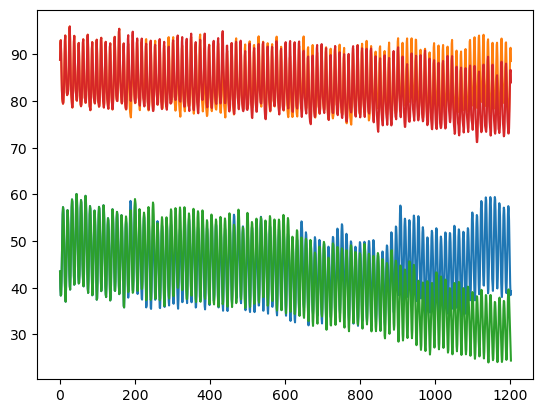

In [128]:
def ext_pole(pole):
    if pole=='Antarctic':
        lmi,lma = -90,-60
    else:
        lmi,lma = 60,90

    AR_hist_yr_ARC = AR_hist.sel(time=slice('2000-01','2014-12'),lat=slice(lmi,lma))
    #AR_hist_yr_ARC = AR_hist_yr_ARC.resample(time='3M').sum()
    AR_hist_yr_ARC = AR_hist_yr_ARC.reduce(np.mean,dim=('lat','lon'))
    histar = AR_hist_yr_ARC.tas.values

    arc245 = AR_fut2.sel(lat=slice(lmi,lma))
    #arc245 = arc245.resample(time='3M').sum()
    arc245 = arc245.reduce(np.mean,dim=('lat','lon')).tas.values

    arc585 = AR_fut5.sel(lat=slice(lmi,lma))
    #arc585 = arc585.resample(time='3M').sum()
    arc585 = arc585.reduce(np.mean,dim=('lat','lon')).tas.values

    arc245 = np.append(histar,arc245)
    arc585 = np.append(histar,arc585)
    
    arc245 = moving_average(arc245,9)
    arc585 = moving_average(arc585,9)
    
    return arc245,arc585
    
n245,n585 = ext_pole('Arctic')
s245,s585 = ext_pole('Antarctic')

mini = np.min([np.minimum(n245,n585),np.minimum(s245,s585)])
maxi = np.max([np.maximum(n245,n585),np.maximum(s245,s585)])

n245 = (n245-mini)/(maxi-mini)
n585 = (n585-mini)/(maxi-mini)
s245 = (s245-mini)/(maxi-mini)
s585 = (s585-mini)/(maxi-mini)

n245_ = minpitch+n245*(maxpitch-minpitch)
n585_ = minpitch+n585*(maxpitch-minpitch)
s245_ = minpitch+s245*(maxpitch-minpitch)
s585_ = minpitch+s585*(maxpitch-minpitch)

n245_ = minpitch-n245_+maxpitch
s245_ = minpitch-s245_+maxpitch
n585_ = minpitch-n585_+maxpitch
s585_ = minpitch-s585_+maxpitch

n245_.astype(int)
n585_.astype(int)
s245_.astype(int)
s585_.astype(int)

plt.plot(n245_)
plt.plot(s245_)
plt.plot(n585_)
plt.plot(s585_)
plt.show()

In [122]:
tst_ = pd.DataFrame({'val':n245_,'step':range(len(n245_))})
tst1_ = pd.DataFrame({'val':n585_,'step':range(len(n585_))})
tsts_ = pd.DataFrame({'val':s245_,'step':range(len(s245_))})
tsts1_ = pd.DataFrame({'val':s585_,'step':range(len(s585_))})

In [123]:
def _to_chords_(df, key):
    notes = range(len(np.arange(minpitch,maxpitch+1,1)))
    notes_ = np.arange(minpitch,maxpitch+1,1)
    maj = np.mod(notes,12)==key[0]
    tir = np.mod(notes,12)==key[1]
    qui = np.mod(notes,12)==key[2]
    sev = np.mod(notes,12)==key[3]
    auth = maj+tir+qui
    auth_notes = notes_[auth]
    notin = df.val.values
    i=0
    for nn in notin:
        dist = np.abs(auth_notes-nn)
        tru_note = auth_notes[np.argmin(dist)]
        notin[i] = tru_note
        i=i+1
    df['val'] = notin
    return df

In [124]:
def extract_sdt(indata,nm,kkeys):
    didif = [indata['step'].values[0]]
    indata = _to_chords_(indata,kkeys)
    for i in np.arange(1,len(tst_.val.values)):
        if indata['val'].values[i]==indata['val'].values[i-1]:
            didif = np.append(didif,indata['step'].values[i-1])
        else:
            didif = np.append(didif,indata['step'].values[i])
    indata['dif'] = didif
    steps = indata.groupby(['dif','val'],as_index=False).count().step.values
    vals = (indata.groupby(['dif','val'],as_index=False).mean().val.values).astype(int)
    new_df = pd.DataFrame({'note':vals,
                       'steps':np.cumsum(steps)-np.min(np.cumsum(steps)),
                       'duration':np.append(steps[1:],2),
                      'force':np.repeat(127,len(steps))})
    new_df = new_df[['steps','note','force','duration']]
    for j in np.arange(1,len(new_df.note.values)):
        if new_df.note.values[j] == new_df.note.values[j-1]:
            new_df.steps[j] = new_df.steps.values[j-1]
    dudu = new_df.groupby(['steps'],as_index=False).sum().duration.values
    new_df = new_df.drop_duplicates(['steps','note'])
    new_df.duration = dudu
    new_df['force'] = np.linspace(100,126,len(dudu)).astype(int)
    print(new_df)
    new_df.to_csv(nm)
    return new_df

In [125]:
tst245=extract_sdt(tst_,'arctas245',[0,4,7,10])
extract_sdt(tst1_,'arctas585',[0,4,7,10])
extract_sdt(tsts_,'anttas245',[0,4,7,10])
extract_sdt(tsts1_,'anttas585',[0,4,7,10])

     steps  note  force  duration
0        0    43    100         2
1        2    40    100         3
4        5    48    100         1
5        6    52    100         2
6        8    55    100         3
..     ...   ...    ...       ...
977   1196    60    125         2
978   1198    55    125         1
979   1199    48    125         1
980   1200    43    125         2
981   1202    40    126         3

[818 rows x 4 columns]
     steps  note  force  duration
0        0    43    100         2
1        2    40    100         3
4        5    48    100         1
5        6    52    100         2
6        8    55    100         3
..     ...   ...    ...       ...
962   1197    40    125         2
963   1199    36    125         2
964   1201    31    125         1
965   1202    28    125         1
966   1203    24    126         2

[807 rows x 4 columns]
     steps  note  force  duration
0        0    88    100         2
1        2    91    100         3
3        5    84    100         2


,steps,note,force,duration
0,0,88,100,2
1,2,91,100,3
3,5,84,100,2
4,7,79,100,4
8,11,84,100,1
...,...,...,...,...
933,1197,72,125,2
934,1199,76,125,1
935,1200,84,125,2
936,1202,88,125,1


<AxesSubplot:>

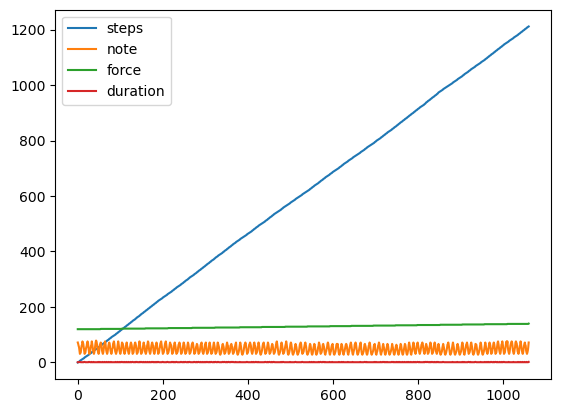

In [93]:
tst245.plot()